# code 3_1_1

In [ ]:
#安装torch相关包
!conda install pytorch torchvision torchaudio pytorch-cuda=11.6 -c pytorch -c nvidia

In [1]:
#测试torch是否安装成功
import torch
x = torch.empty(5,3)
print(x)

tensor([[ 5.6546e-06,  3.0680e-41,  0.0000e+00],
        [ 0.0000e+00,  1.4013e-45,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -6.5197e+22],
        [ 4.5555e-41,  0.0000e+00,  0.0000e+00],
        [ 4.7536e+30,  4.6172e+24,  5.6052e-44]])


In [4]:
#测试能否调用GPU
torch.cuda.is_available()

False

# code 3_1_2

In [ ]:
#安装transfromers
!pip install transformers

In [ ]:
#调用预训练模型mengzi-bert-base，用于后续任务
from transformers import AutoTokenizer
transformer_model_name = "Langboat/mengzi-bert-base"
tokenizer = AutoTokenizer.from_pretrained(
    transformer_model_name
)

# code 3_1_3

In [7]:
#安装small_text
!pip install small_text

Looking in indexes: https://repo.huaweicloud.com/repository/pypi/simple


In [9]:
#调用常用模块
from small_text import TransformersDataset
from small_text import TransformerModelArguments
from small_text import TransformerBasedClassificationFactory

# code 3_2_1

In [52]:
import re

class word_freq():
    def __init__(self, doc_text , key_word, and_words, replace = '[\s\t\n]', sep ='[.。?!？！]'):
        self.doc_text = doc_text
        self.key_word = key_word
        self.and_words = and_words
        self.replace = replace
        self.sep = sep
        
    #第一部分：对政策全文进行语句分割    
    def doc2sen(self):
        doc = re.sub(self.replace, '', self.doc_text) 
        sentence_list = re.split(self.sep, self.doc_text)
        return sentence_list
    
    #第二部分：判断每个语句中是否含有该搭配规则
    def sen_freq(self, sentence):
        
        count = 0
        key_word_count = sentence.count(self.key_word)
    
        flag = 0
        for i in self.and_words:
            flag += sentence.count(i)
        if len(self.and_words) == 0:
            flag = 1
        and_words_count = flag
        
        if key_word_count > 0 and and_words_count > 0:
            count = 1
        
        return count 
            
    #第三部分：对政策全文进行加总统计
    def count(self):
        self.sentence_list = self.doc2sen()
        count = 0
        for sentence in self.sentence_list:
            count += self.sen_freq(sentence)
        return count

# code 3_2_2

In [53]:
doc_text = """全面推进按病种付费、按人头付费、按床日付费等复合型支付方式改革，开展按疾病诊断相关分组（DRGs）收付费试点，
进一步扩大支付方式改革对定点医疗机构和参合患者的覆盖面。将对医疗机构个体的总额控制转变为区域内总额控制，探索开展点数法付费。
建立健全支付方式改革联系点工作机制，加强对支付方式改革的指导、评估和总结。助力分级诊疗制度建设，将符合规定的家庭医生签约服
务费纳入医保支付范围。支持区域医疗服务一体化改革，探索通过总额预付等支付政策的引导与调控，促进城市紧密型医联体、县域医共体
内各级医疗机构规范服务、上下联动、分工协作、主动控费。启动实施按照药品通用名称制订新农合药品支付标准，配合做好医疗服务价格
改革，探索制订新农合医疗服务支付标准，协同推进药品和医疗服务价格改革。"""

In [54]:
key_word = '总额控制'
and_words = []
freq = word_freq(doc_text, key_word, and_words).count()
freq

1

In [56]:
key_word = '按人头'
and_words = ['推进']
freq = word_freq(doc_text, key_word, and_words).count()
freq

1

# code 3_3_1

In [1]:
import datasets
import torch

import pandas as pd
import numpy as np

import logging
logging.getLogger('small_text').setLevel(logging.INFO)
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import accuracy_score
from transformers import AutoTokenizer
from small_text import TransformersDataset
from small_text import TransformerModelArguments
from small_text import TransformerBasedClassificationFactory,

# fix the random seed
seed = 2022
torch.manual_seed(seed)
np.random.seed(seed)

In [39]:
#第一部分：数据预处理
df = pd.read_csv('sample_多分类.csv')
df['label'] = 0
df.loc[df['categories']=='支付方式改革','label'] = 1
#df.head(3)
train = df.sample(frac=0.8)
test = df[~df.index.isin(train.index)]
num_classes = np.unique(train['label']).shape[0]

print('训练集数量为：',len(train),
      '\n测试集数量为：',len(test),
      '\n标签类数量为：',num_classes)

训练集数量为： 34704 
测试集数量为： 8676 
标签类数量为： 2


In [4]:
#第二部分：训练模型

## 将文本数据封装
transformer_model_name = "Langboat/mengzi-bert-base"
tokenizer = AutoTokenizer.from_pretrained(
    transformer_model_name
)
transformer_model = TransformerModelArguments(transformer_model_name)
train = TransformersDataset.from_arrays(list(train['text']),
                                        list(train['label']),
                                        tokenizer,
                                        max_length=90)
test = TransformersDataset.from_arrays(list(test['text']), 
                                       list(test['label']),
                                       tokenizer,
                                       max_length=90)

34704it [00:07, 4944.95it/s]
8676it [00:01, 4932.36it/s]


In [5]:
## 加载预训练模型
transformer_model = TransformerModelArguments(transformer_model_name)
clf_factory = TransformerBasedClassificationFactory(transformer_model, 
                                                    num_classes, 
                                                    kwargs=dict({'device': 'cuda', 
                                                                 'mini_batch_size': 256,
                                                                 'class_weight': 'balanced',
                                                                 'num_epochs': 20
                                                                }))

In [6]:
## 使用训练集进行训练
clf = clf_factory.new().fit(train)

123it [01:06,  1.86it/s]
100%|██████████| 14/14 [00:02<00:00,  5.61it/s]
INFO:small_text.integrations.transformers.classifiers.classification:Epoch: 1 | 00:01:09
	Train Set Size: 31233
	Loss: 0.0012(train)	|	Acc: 97.8%(train)
	Loss: 0.0004(valid)	|	Acc: 98.7%(valid)
123it [01:06,  1.84it/s]
100%|██████████| 14/14 [00:02<00:00,  5.55it/s]
INFO:small_text.integrations.transformers.classifiers.classification:Epoch: 2 | 00:01:10
	Train Set Size: 31233
	Loss: 0.0002(train)	|	Acc: 99.4%(train)
	Loss: 0.0003(valid)	|	Acc: 99.1%(valid)
123it [01:07,  1.83it/s]
100%|██████████| 14/14 [00:02<00:00,  5.53it/s]
INFO:small_text.integrations.transformers.classifiers.classification:Epoch: 3 | 00:01:11
	Train Set Size: 31233
	Loss: 0.0001(train)	|	Acc: 99.7%(train)
	Loss: 0.0003(valid)	|	Acc: 99.0%(valid)
123it [01:07,  1.83it/s]
100%|██████████| 14/14 [00:02<00:00,  5.52it/s]
INFO:small_text.integrations.transformers.classifiers.classification:Epoch: 4 | 00:01:11
	Train Set Size: 31233
	Loss: 0.0001(

In [7]:
#第三部分：测试模型精度
clf.validate(test)

100%|██████████| 34/34 [00:06<00:00,  5.57it/s]


(0.00021109832221566567, 0.9949285384970032)

# code 3_3_2

In [35]:
def pred(text, model):
    pred_df = TransformersDataset.from_arrays([text],[0],tokenizer,max_length=90)
    output = model.predict_proba(pred_df)
    print(" 预测为非支付方式改革的概率为{:.4f}%\n".format(output[0][0]*100),
          "预测为支付方式改革的概率为{:.4f}%".format(output[0][1]*100))

In [36]:
text = """全面推进按病种付费、按人头付费、按床日付费等复
合型支付方式改革，开展按疾病诊断相关分组（DRGs）收付费试点，
进一步扩大支付方式改革对定点医疗机构和参合患者的覆盖面。"""
model = clf

In [37]:
pred(text, model)

1it [00:00, 1258.04it/s]
100%|██████████| 1/1 [00:00<00:00, 111.01it/s]

 预测为非支付方式改革的概率为0.0012%
 预测为支付方式改革的概率为99.9988%


# code 3_4_1

## 1) 导入数据集，加载模型

In [1]:
import datasets
import torch

import pandas as pd
import numpy as np

import logging
logging.getLogger('small_text').setLevel(logging.INFO)
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import accuracy_score
from transformers import AutoTokenizer
from small_text import TransformersDataset
from small_text import TransformerModelArguments
from small_text import (
    PoolBasedActiveLearner,
    PredictionEntropy,
    TransformerBasedClassificationFactory,
    random_initialization_balanced,
    random_initialization)

# fix the random seed
seed = 2022
torch.manual_seed(seed)
np.random.seed(seed)

In [2]:
df = pd.read_csv('sample_多分类.csv')
df['label'] = 0
df.loc[df['categories'] == '支付方式改革','label'] = 1
#df.head(3)
train = df.sample(frac = 0.8)
test = df[~df.index.isin(train.index)]
num_classes = np.unique(train['label']).shape[0]

print('训练集数量为：',len(train),
      '\n测试集数量为：',len(test),
      '\n标签类数量为：',num_classes)

训练集数量为： 34704 
测试集数量为： 8676 
标签类数量为： 2


In [3]:
transformer_model_name = "Langboat/mengzi-bert-base"
tokenizer = AutoTokenizer.from_pretrained(
    transformer_model_name
)

transformer_model = TransformerModelArguments(transformer_model_name)
train_da = TransformersDataset.from_arrays(list(train['text']),
                                        list(train['label']),
                                        tokenizer,
                                        max_length=90)
test_da = TransformersDataset.from_arrays(list(test['text']), 
                                       list(test['label']),
                                       tokenizer,
                                       max_length=90)

transformer_model = TransformerModelArguments(transformer_model_name)
clf_factory = TransformerBasedClassificationFactory(transformer_model, 
                                                    num_classes, 
                                                    kwargs=dict({'device': 'cuda', 
                                                                 'mini_batch_size': 128,
                                                                 'class_weight': 'balanced',
                                                                 'num_epochs': 20
                                                                }))

34704it [00:06, 5016.15it/s]
8676it [00:01, 4963.12it/s]


## 2) 标注初始训练预料，训练并测试模型

In [4]:
## 初始100个语料
indices_initial = random_initialization(train_da, n_samples = 100)
train.iloc[indices_initial,:]

,id,text,categories,label
15861,17079,鼓励社会资本举办专科，支持社会资本举办高端；控制开展特需服务的比例,非支付方式改革,0
11172,12074,放宽服务领域要求，凡是法律法规没有明令禁入的领域，均向社会资本开放,非支付方式改革,0
31430,35047,省医保局第一时间主持召开党组（扩大）会议，传达学习《中共中央国务院关于深化医疗保障制度改革的...,非支付方式改革,0
18052,19562,（二）推进医联体内部资源整合,非支付方式改革,0
19608,21296,2015年10月28日,非支付方式改革,0
...,...,...,...,...
29062,32283,90日内跨年度办理转移接续手续的，可自愿选择是否补缴上年度医保费（包括个人缴费和各级财政补助...,非支付方式改革,0
20621,22414,改革要与地区经济社会和医疗卫生事业发展水平相协调，与财政和医疗保障承受能力相适应，鼓励结合实...,非支付方式改革,0
7254,7687,“十二五”以来，特别是党的十八大以来，在市委市政府的坚强领导下，全市认真贯彻落实中央以及省上...,非支付方式改革,0
36915,42077,"严格执行医院财务会计制度,实行总会计师制",非支付方式改革,0


In [5]:
## 训练模型
query_strategy = PredictionEntropy()
active_learner = PoolBasedActiveLearner(clf_factory, query_strategy, train_da)
active_learner.initialize_data(indices_initial, train_da.y[indices_initial])

1it [00:00,  4.56it/s]
100%|██████████| 1/1 [00:00<00:00, 93.82it/s]
INFO:small_text.integrations.transformers.classifiers.classification:Epoch: 1 | 00:00:01
	Train Set Size: 90
	Loss: 0.0097(train)	|	Acc: 95.6%(train)
	Loss: 0.1483(valid)	|	Acc: 90.0%(valid)
1it [00:00,  4.58it/s]
100%|██████████| 1/1 [00:00<00:00, 96.09it/s]
INFO:small_text.integrations.transformers.classifiers.classification:Epoch: 2 | 00:00:01
	Train Set Size: 90
	Loss: 0.0093(train)	|	Acc: 95.6%(train)
	Loss: 0.1462(valid)	|	Acc: 90.0%(valid)
1it [00:00,  4.52it/s]
100%|██████████| 1/1 [00:00<00:00, 89.52it/s]
INFO:small_text.integrations.transformers.classifiers.classification:Epoch: 3 | 00:00:01
	Train Set Size: 90
	Loss: 0.0087(train)	|	Acc: 95.6%(train)
	Loss: 0.1443(valid)	|	Acc: 90.0%(valid)
1it [00:00,  4.58it/s]
100%|██████████| 1/1 [00:00<00:00, 91.33it/s]
INFO:small_text.integrations.transformers.classifiers.classification:Epoch: 4 | 00:00:01
	Train Set Size: 90
	Loss: 0.0090(train)	|	Acc: 95.6%(train)
	

In [6]:
## 测试模型精度
active_learner.classifier.validate(test_da)

100%|██████████| 68/68 [00:06<00:00, 10.92it/s]


(0.006701560830976514, 0.9416781927155371)

In [7]:
def pred(text, model):
    pred_df = TransformersDataset.from_arrays([text],[0],tokenizer,max_length=90)
    output = model.predict_proba(pred_df)
    print(" 预测为非支付方式改革的概率为{:.4f}%\n".format(output[0][0]*100),
          "预测为支付方式改革的概率为{:.4f}%".format(output[0][1]*100))

In [8]:
text = """全面推进按病种付费、按人头付费、按床日付费等复
合型支付方式改革，开展按疾病诊断相关分组（DRGs）收付费试点，
进一步扩大支付方式改革对定点医疗机构和参合患者的覆盖面。"""
model = active_learner.classifier

In [9]:
pred(text, model)

1it [00:00, 790.33it/s]
100%|██████████| 1/1 [00:00<00:00, 67.93it/s]

 预测为非支付方式改革的概率为80.3474%
 预测为支付方式改革的概率为19.6525%


## 3) 标注主动选取预料，更新并测试模型

In [10]:
# 主动选取100语料，打上标签
indices_queried = active_learner.query(num_samples = 100)
train.iloc[indices_queried,:]

100%|██████████| 272/272 [00:24<00:00, 10.91it/s]


,id,text,categories,label
22748,24709,改革完善医疗质量技木、安全和服务评估认证制度，健全市、旗县两级医疗质量控制组织,非支付方式改革,0
32116,36069,完善不同级别医疗机构的医保差异化支付政策，结合分级诊疗模式和家庭医生签约服务制度建设，引导参...,非支付方式改革,0
3537,3646,4.完善医务人员评价制度,非支付方式改革,0
25956,28501,完善药品储备制度，在应急保障的基础上，完善常态短缺药品储备，保证应急药品和基本药物及时供应,非支付方式改革,0
42071,49108,依托基层定点医疗机构开展门诊统筹，门诊统筹实行按人头付费。通过个人账户功能拓展等方式，逐步实...,支付方式改革,1
...,...,...,...,...
11966,12900,强化医疗卫生服务行为和质量监管,非支付方式改革,0
41923,48636,全面推行总额控制下的按病种分值结算。各县区要将总额控制与病种分值付费相结合，在确定本地区住院...,支付方式改革,1
42988,50935,完善城乡居民医保门诊医疗保障政策，兼顾普通门诊和门诊大病医疗需求，按照城乡居民医保基金总额1...,非支付方式改革,0
24513,26760,完善医保关系转移接续政策，基本实现职工医保制度内跨区域转移接续，切实落实各项基本医疗保险制度,非支付方式改革,0


In [11]:
# 使用新加入的语料进行训练
y = train_da.y[indices_queried]
active_learner.update(y)

2it [00:00,  4.54it/s]
100%|██████████| 1/1 [00:00<00:00, 48.29it/s]
INFO:small_text.integrations.transformers.classifiers.classification:Epoch: 1 | 00:00:01
	Train Set Size: 180
	Loss: 0.0080(train)	|	Acc: 80.6%(train)
	Loss: 0.0335(valid)	|	Acc: 75.0%(valid)
2it [00:00,  4.49it/s]
100%|██████████| 1/1 [00:00<00:00, 48.81it/s]
INFO:small_text.integrations.transformers.classifiers.classification:Epoch: 2 | 00:00:01
	Train Set Size: 180
	Loss: 0.0075(train)	|	Acc: 86.1%(train)
	Loss: 0.0322(valid)	|	Acc: 100.0%(valid)
2it [00:00,  4.51it/s]
100%|██████████| 1/1 [00:00<00:00, 48.08it/s]
INFO:small_text.integrations.transformers.classifiers.classification:Epoch: 3 | 00:00:01
	Train Set Size: 180
	Loss: 0.0071(train)	|	Acc: 91.1%(train)
	Loss: 0.0295(valid)	|	Acc: 100.0%(valid)
2it [00:00,  4.54it/s]
100%|██████████| 1/1 [00:00<00:00, 47.53it/s]
INFO:small_text.integrations.transformers.classifiers.classification:Epoch: 4 | 00:00:01
	Train Set Size: 180
	Loss: 0.0067(train)	|	Acc: 92.8%(tr

In [12]:
# 测试模型精度
active_learner.classifier.validate(test_da)

100%|██████████| 68/68 [00:06<00:00, 10.88it/s]


(0.0029292461329640854, 0.9586214845550945)

In [13]:
text = """全面推进按病种付费、按人头付费、按床日付费等复
合型支付方式改革，开展按疾病诊断相关分组（DRGs）收付费试点，
进一步扩大支付方式改革对定点医疗机构和参合患者的覆盖面。"""
model = active_learner.classifier

In [14]:
pred(text, model)

1it [00:00, 923.04it/s]
100%|██████████| 1/1 [00:00<00:00, 101.28it/s]

 预测为非支付方式改革的概率为7.1958%
 预测为支付方式改革的概率为92.8042%


# pic 1

In [6]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 必要时终端运行命令：chmod -R 777 /root/autodl-tmp/

#不带标签的数据
with sqlite3.connect('/root/autodl-tmp/corpus.sqlite') as con:
    sql = "select * from '医疗政策语料' order by random() limit 10000"
    df = pd.read_sql(sql, con = con)  
unlabeled = df

In [15]:
import matplotlib
from matplotlib.font_manager import FontProperties  
font = FontProperties(fname = "/root/font/simsun.ttc", size=14)

In [16]:
# 文本长度分布
unlabeled['text_length'] = unlabeled['text'].str.len()

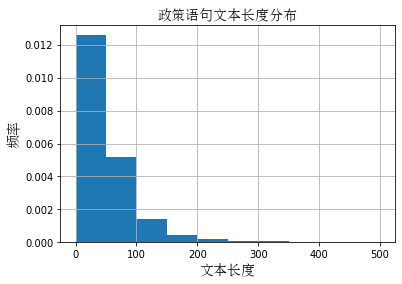

In [18]:
unlabeled['text_length'].hist(range=(0,500),  density = True)
plt.xlabel('文本长度',fontproperties = font)
plt.ylabel('频率',fontproperties = font)
plt.title('政策语句文本长度分布',fontproperties = font)
plt.show()